In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast

In [ ]:
data = pd.read_csv(r'C:\Users\giuli\Documents\GitHub\Progetto_BI2021\data.csv', parse_dates=['created_at'])
df = pd.DataFrame(data)

## DECODING DEL TESTO ALL INTERNO DELLA COLONNA `text`. 
All interno della colonna text è presente una rappresentazione di un bytes sotto forma di stringa. Questa può essere valutata attraverso la funzione `ast.literal_eval(string)` e quindi decodificata
#secondo la codifica appropriata tramite il metodo decode

In [ ]:
text_enc = []
for i in range(0, df.text.size):
    txt= ast.literal_eval(df.text[i]).decode('utf-8')
    text_enc.append(txt)

df['text_enc'] = text_enc
df

## Pulizia dei Tweet
Attraverso le Regular Expressions vado a rimuovere elementi come:
* @menzioni
* Hashtag
* Link

In [ ]:
import re

def cleanTxt(text):
 text = re.sub('@[A-Za-z0–9]+', '', text) #Rimuove le @menzioni
 text = re.sub('#', '', text) # Rimuove l'hashtag
 text = re.sub('https?:\/\/\S+', '', text) # Rimuove i link
 text = re.sub('&amp', '', text) #Rimuove &amp
 return text

df['text_clean'] = df.text_enc.apply(cleanTxt)


## Language Detection
il metodo `detect_langs` fornisce un vettore di possibilità riguardo la lingua del testo che sta analizzando. Vado a vedere se ci sono nel dataset testi ambigui (quindi quelli per cui la dimensione del `dict` ritornato da `detect_langs` è maggiore di 1).

Utilizzo `langdetect` che è abbastanza veloce per generare una previsione sommaria. Esso restituisce la probabilità per ciascuna lingua trovata quindi:
* se trovo una sola lingua tra quelle ammesse (en, es, fr) allora segno la lingua trovata e segno la detection come sicura
* se trovo più di una lingua oppure trovo come lingua più probabile una non ammessa segno la lingua e segno la detection come insicura/sbagliata (`unsure_wrong_detection=True`) 

In [ ]:
from langdetect import detect_langs

unsure_count = 0
wrong_count = 0
i=0
lang_detect = []
unsure_wrong = []

for twt in df.text_enc:
    try:
        detection = detect_langs(twt)
        lang = detection[0].lang
        
        lang_detect.append(lang)
        unsure_wrong.append(False)
        
        if((lang != "en") and (lang != "es") and (lang != "fr")):
             wrong_count = wrong_count +1
             unsure_wrong[i]=True
        if(len(detection)>1):
            unsure_wrong[i]=True
            unsure_count = unsure_count+1

    except:
        print("errore alla posizione ")
        i
        print("testo : " + twt)
        lang_detect.append('None')
        unsure_wrong.append(True)

    i=i+1



df['langdetect']=lang_detect
df['unsure_wrong_detection'] = unsure_wrong

unsure_wrong_sum = df['unsure_wrong_detection'].sum()
unsure_wrong_sum

# Check traduzione attraverso API Google 
I tweet dei quali la traduzione non è sicura sono stati marcati con un `True` all'interno della colonna `unsure_wrong_detection`. Utilizzo questa informazione per passare i questi tweet all'interno dell'API Google per la traduzione. Questo metodo non è stato utilizzato prima in quanto le possibili chiamate ai server Google sono limitate e molto lente.

In [ ]:
from textblob import TextBlob

lang_detect_final = []
i = 0
for twt in df.text_clean:
    if not df['unsure_wrong_detection'][i]:
        lang_detect_final.append(df['langdetect'][i])
    else:
        blob = TextBlob(twt)
        lang = blob.detect_language()
        if((lang != "en") and (lang != "es") and (lang != "fr")):
            lang_detect_final.append('None')
        else:
            lang_detect_final.append(lang)
            df['unsure_wrong_detection'][i]=False
    i=i+1

df['lang_detect_final'] = lang_detect_final

In [ ]:
df.unsure_wrong_detection.sum()

## Esportazione dei dati su formato Excel
Excel non supporta le date con le timezone quindi le ho dovute eliminare con il metodo `datetime.tz_localize()`

In [ ]:
df_enc = df[['favorite_count', 'source', 'text_enc', 'text_clean', 'is_retweet', 'retweet_count', 'created_at', 'langdetect', 'unsure_wrong_detection', 'lang_detect_final']]
df_enc.loc[:,'created_at_ntz']= df_enc.created_at.dt.tz_localize(None)
df_enc.drop(columns='created_at')
df_enc = df_enc.drop(columns='created_at')
df_enc.to_excel('data_dec.xlsx')

# Inizio dell'analisi
Dopo aver salvato i dati ripuliti all'interno del file Excel, uso questo come checkpoint per partire con l'analisi. Questo perché non è sempre possibile performare di nuovo la traduzione a causa delle restrizioni dell'api di Google descritte sopra

Dal momento che i Tweet la cui lingua non è stata riconosciuta sono meno dell' 1%, questi vengono filtrati. Dopodiché il dataset viene splittato per lingua in tre ```DataFrame``` 


In [99]:
data=pd.read_excel(r'C:\Users\giuli\Documents\GitHub\Progetto_BI2021\data_dec.xlsx')
df=pd.DataFrame(data)

df = df.drop(columns='langdetect')
df.loc[df['unsure_wrong_detection']==True].shape #controllo dei tweet la cui lingua non è stata riconosciuta
df = df.loc[df['unsure_wrong_detection']==False] #filtraggio dei tweet non riconosciuti

### Suddivisione dei Dataset per lingua ###

#en
df_en = df.loc[df['lang_detect_final']=='en']
df_en = df_en.drop(columns=['lang_detect_final', 'unsure_wrong_detection'])

#es
df_es = df.loc[df['lang_detect_final']=='es']
df_es = df_es.drop(columns=['lang_detect_final', 'unsure_wrong_detection'])

#fr
df_fr = df.loc[df['lang_detect_final']=='fr']
df_fr = df_fr.drop(columns=['lang_detect_final', 'unsure_wrong_detection'])


In [100]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfVectorizer = TfidfVectorizer(min_df=0.01, stop_words='english')
tfidf_en_matrix = tfidfVectorizer.fit_transform(df_en.text_clean.astype('str'))

## Conversione TfIdf in Dataframe ##

# tfidfVectorizer ritorna una matrice sparsa che non permette la visualizzazione agevole della matrice TfIdf

tf_idf_en = pd.DataFrame(columns=tfidfVectorizer.get_feature_names(), index=df_en.text_clean, dtype=float)

M = tfidf_en_matrix.todense()
for i in range(0, df_en.shape[0]):
    tf_idf_en.iloc[i, :]=M[i,:]

## classifica delle parole
score={}
for word in tfidfVectorizer.get_feature_names():
    score[word]= tf_idf_en[word].mean()

dict(sorted(score.items(), key=lambda item: item[1], reverse=True))

{'covid': 0.11990657249189288,
 '19': 0.11390191481178064,
 'covid19': 0.07933897347734718,
 'coronavirus': 0.06140898933125699,
 'vaccine': 0.056349183986664844,
 'amp': 0.033106438440200725,
 'pandemic': 0.032974194651348904,
 'people': 0.030495982734233203,
 'new': 0.030417937335814778,
 'cases': 0.022971349771716512,
 'vaccines': 0.02209987753726894,
 'health': 0.020383401176883656,
 'just': 0.019403862020899967,
 'news': 0.018699068352075198,
 'year': 0.018373225101659823,
 'vaccination': 0.018292272399737415,
 'time': 0.016908429045081348,
 'texas': 0.01625638232070782,
 'relief': 0.015982304850626506,
 'march': 0.015231037865094835,
 'deaths': 0.015230678494249042,
 'mask': 0.01427997655382682,
 'like': 0.014168438480215312,
 'help': 0.013971165122156166,
 'don': 0.013744307648324912,
 'state': 0.013460586608933863,
 'need': 0.01323262370451596,
 'today': 0.012911115372228001,
 'make': 0.012697312254156334,
 'know': 0.011944353369159699,
 'virus': 0.011909862600992542,
 'vaccina

In [101]:
score

{'000': 0.011262735630757045,
 '10': 0.006778586957959099,
 '100': 0.006008480014126547,
 '19': 0.11390191481178064,
 '2020': 0.007941682727633376,
 '2021': 0.011129852003831325,
 'americans': 0.0067726258125812245,
 'amp': 0.033106438440200725,
 'biden': 0.01070590094275285,
 'canada': 0.006034467030445575,
 'care': 0.008804048889511485,
 'case': 0.006752959802968259,
 'cases': 0.022971349771716512,
 'check': 0.0074983722105421554,
 'children': 0.007076240722380959,
 'china': 0.010989396774879642,
 'coronavirus': 0.06140898933125699,
 'country': 0.007900401693776036,
 'county': 0.010318421776000262,
 'covid': 0.11990657249189288,
 'covid19': 0.07933897347734718,
 'daily': 0.006871006256890259,
 'data': 0.010421555943603038,
 'day': 0.00895319412372375,
 'days': 0.006630885050704521,
 'death': 0.007990334349031573,
 'deaths': 0.015230678494249042,
 'did': 0.007884806925932119,
 'died': 0.006293848522641427,
 'does': 0.007298842196433517,
 'don': 0.013744307648324912,
 'dose': 0.0061229

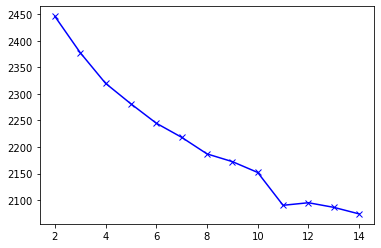

In [102]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

SSD = []
K=range(2,15)

for k in K:
    km=KMeans(n_clusters=k, max_iter=200, n_init=10)
    km = km.fit(tfidf_en_matrix)
    SSD.append(km.inertia_)

plt.plot(K, SSD, 'bx-')

In [103]:
k=5

model = KMeans(n_clusters=k)
model.fit(tfidf_en_matrix)
labels=model.labels_

df_en['label']=labels


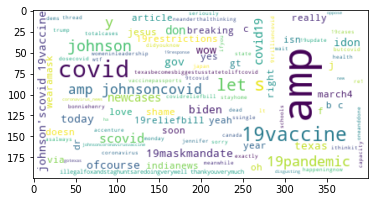

In [104]:

from wordcloud import WordCloud

df_en_0 = df_en.loc[df_en['label']==4]
text = df_en_0['text_clean'].str.cat(sep='')
text = text.lower()
text=''.join([word for word in text.split()])
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.imshow(wordcloud, interpolation="bilinear")

## Riprovo tutto con stemming

In [129]:
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

porter = PorterStemmer()


text_stem = []
#df_en['text_clean']=df_en['text_clean'].astype('str')
for twt in df_en.text_clean:
    tweet = twt.lower()
    token_words = word_tokenize(tweet)
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(' ')
    
    text_stem.append(''.join(stem_sentence))

df_en['text_stem']=text_stem

In [130]:
df_en

,Unnamed: 0,favorite_count,source,text_enc,text_clean,is_retweet,retweet_count,created_at_ntz,label,text_stem
1,1,0,Twitter for iPhone,@TitusNation the CON serving CONservative GOP ...,the CON serving CONservative GOP = Ghouls of ...,False,0,2021-03-03 17:22:21,1,"the con serv conserv gop = ghoul of polit , gr..."
2,2,0,Twitter for Android,#Coronavirus\nAustria and Denmark are to stop ...,Coronavirus\nAustria and Denmark are to stop r...,False,0,2021-03-03 08:47:26,0,coronaviru austria and denmark are to stop rel...
3,3,0,Twitter Web App,BMC launches ‘Mission Zero’ in Mumbai again to...,BMC launches ‘Mission Zero’ in Mumbai again to...,False,0,2021-03-01 12:23:57,3,bmc launch ‘ mission zero ’ in mumbai again to...
4,4,0,Twitter for iPhone,@Gadaffyduck @IsabelOakeshott @AmandaHolden Du...,Dude.. y’all sound like the idiots. Y’all b...,False,0,2021-03-04 20:49:11,4,dude .. y ’ all sound like the idiot . y ’ all...
5,5,0,Hootsuite Inc.,COVID-19 Shows Need for New Nursing Home Model...,COVID-19 Shows Need for New Nursing Home Model...,False,0,2021-03-01 20:45:03,4,covid-19 show need for new nurs home model — b...
...,...,...,...,...,...,...,...,...,...,...
4163,4163,4,Tweetbot for Mac,"In other news, I have been jabbed with the fir...","In other news, I have been jabbed with the fir...",False,0,2021-03-02 19:18:52,3,"in other news , i have been jab with the first..."
4164,4164,5,Twitter Web App,So nearly 10% of today's new cases are the new...,So nearly 10% of today's new cases are the new...,False,4,2021-03-04 22:56:28,4,so nearli 10 % of today 's new case are the ne...
4165,4165,2,Twitter for Android,"Read this\n\nThen read it again\n\nWritten, pr...","Read this\n\nThen read it again\n\nWritten, pr...",False,1,2021-03-04 07:46:47,4,"read thi then read it again written , presum b..."
4166,4166,8,Twitter Web App,‼️Update‼️ Individuals who file an IRS Form 1...,‼️Update‼️ Individuals who file an IRS Form 1...,False,4,2021-03-04 12:39:09,4,"‼️update‼️ individu who file an ir form 1040 ,..."
